In [4]:
import numpy as np 
import matplotlib.pyplot as plt 
from astropy.io import fits

We first have to start defining the model itself. Let's start by writing down our function.

We jus saw in class that M-E assumption, where line profile is constant with depth looks like: 
$$I_\lambda = S_0 + \frac{S_1}{1+\eta \phi_\lambda(\lambda_0,\sigma,a)} $$

Where $S_0$ and $S_1$ determine the depth dependence of the source function, $\eta$ is line-to-continuum opacity ratio, $\lambda_0$ is line center position, $\sigma$ Doppler width and $a$ is the damping.

In [19]:
# Let's start with the profile, which is the most tricky part of the game:

from scipy.special import wofz

# This is the original formulation of Voigt function, by using wofz
def V(x, alpha, gamma):
    
    #Return the Voigt line shape at x with Lorentzian component HWHM gamma
    #and Gaussian component HWHM alpha.

    sigma = alpha / np.sqrt(2 * np.log(2))

    return np.real(wofz((x + 1j*gamma)/sigma/np.sqrt(2))) / sigma /np.sqrt(2*np.pi)

# This is a formulation where we "normalize" the wavelengths in order to get a dimensionless
# wavelength. It should work either way...

def voigt(center,doppler,damp,ll):
    
    xx = (ll - center)/doppler
    return V(xx,1.0,damp)

In [20]:
# Now let's define our model. Model takes the parameters p, that are going to change from 
# example to example, and wavleengths ll, that are going to stay the same

def me_scalar(p,ll):
    
    # we have 6 parameters:
    S0 ,S1, eta, shift, width, damping = p
    
    # Note that we have here replaced the line center position with "shift", se below:
    center = 6301.49 * (1.+shift/2.997E5)
    
    # Also, let's assume width was also provided in km/s. Here we transform it to wavle 
    width *= 6301.49/2.997E5
    
    
    profile = voigt(center,width,damping,ll)
    
    return S0 + S1/(1.+profile*eta)

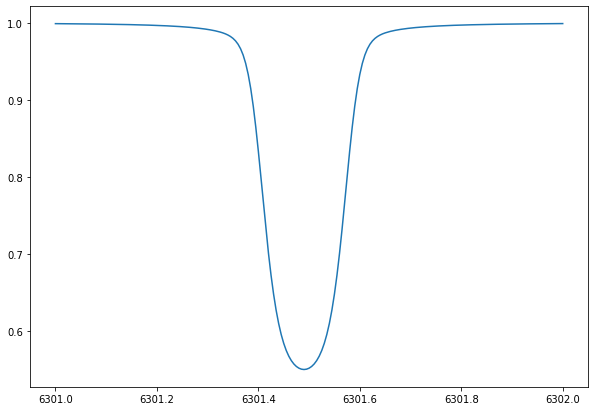

In [11]:
# Let's see if it works
S0 = 0.5
S1 = 0.5
eta = 20.0
shift = 0.0
width = 2.0 
damping = 0.05
ll = np.linspace(6301.,6302.,201)

spec = me_scalar([S0,S1,eta,shift,width,damping],ll)

plt.figure(figsize=[10,7])
plt.plot(ll,spec)


Looks good! Now time to experiment with some parameters. Let's first consider something that we all feel should be important line strength.

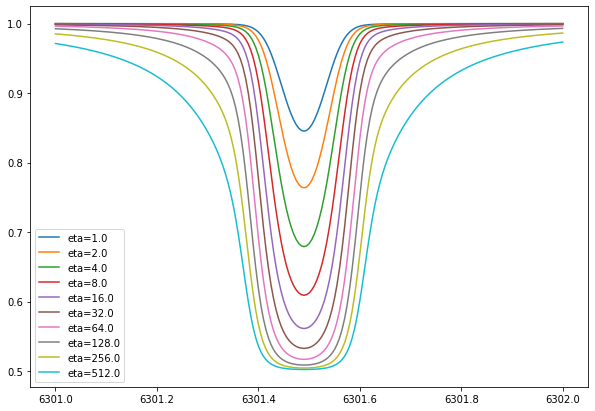

In [21]:
etavar = 1.0

plt.figure(figsize=[10,7])

for i in range(0,10):
    spec = me_scalar([S0,S1,etavar,shift,width,damping],ll)
    plt.plot(ll,spec,label='eta='+str(etavar))
    etavar *= 2.0

plt.legend()

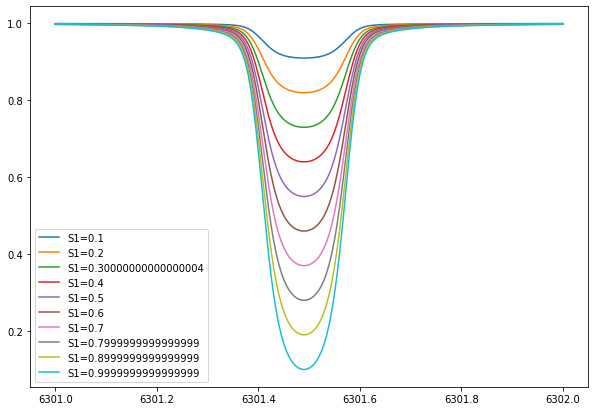

In [24]:
#Now the slope of the source functionbrew install eigen
S1var = 0.1

plt.figure(figsize=[10,7])

for i in range(0,10):
    spec = me_scalar([1.0-S1var,S1var,eta,shift,width,damping],ll)
    plt.plot(ll,spec,label='S1='+str(S1var))
    S1var += 0.1

plt.legend()

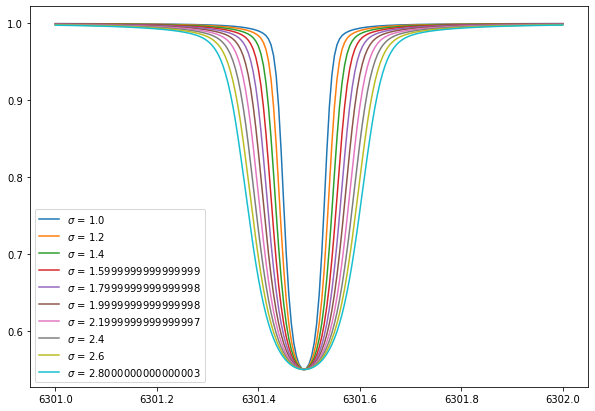

In [27]:
# And now the width
widthvar = 1.0 # in km/s

plt.figure(figsize=[10,7])

for i in range(0,10):
    spec = me_scalar([S0,S1,eta,shift,widthvar,damping],ll)
    plt.plot(ll,spec,label='$\sigma$ = '+str(widthvar))
    widthvar += 0.2

plt.legend()

In [29]:
# Let's first look at the data
stokes = fits.open("/home/milic/data/Hinode_network/hinode_network_c.fits")[0].data
stokes.shape

(512, 873, 4, 112)

In [30]:
stokes.shape
stokes /= np.mean(stokes[:,:,0,:10])

In [33]:
# Let's also assign wavelengths:
ll = np.linspace(0,111,112)
ll = 6302.08 + (ll-56.5)*0.0215

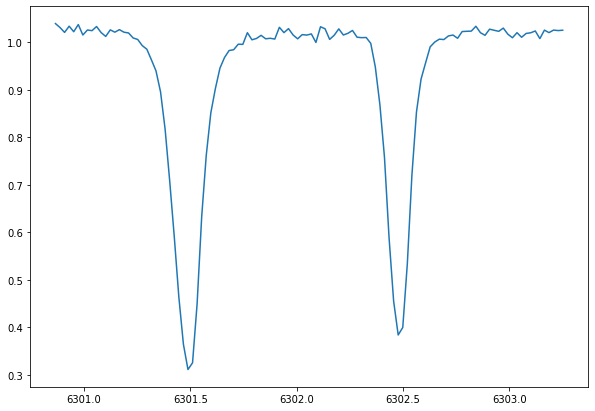

In [34]:
# Plot one spectrum:
plt.figure(figsize=[10,7])
plt.plot(ll,stokes[100,100,0,:])

In [35]:
#let's try now scipy.optimize.minimize

def chi2(params, x, y, error):
    
    #x is ll
    #y are the observed stokes 
    #uncertanties in y
    
    y_model = me_scalar(params,x)
    
    chi2 = np.sum(((y_model - y) / error)**2)
    
    return chi2

In [53]:
from scipy.optimize import minimize
x_data = ll[:50]
y_data = stokes[100,100,0,:50]
errors = 1E-3

starting_params=[0.5,0.5,20.0,0.0,2.0,0.05]

result = minimize(chi2,starting_params,args=(x_data,y_data,errors),bounds=[(0.2,0.4),(0.5,1.0),(1,100),(-20,20),(0.5,5.0),(0,1)])
print (result.x)
    

[ 0.20069508  0.83846186 19.78032932 -0.15041536  1.33357802  0.61059568]


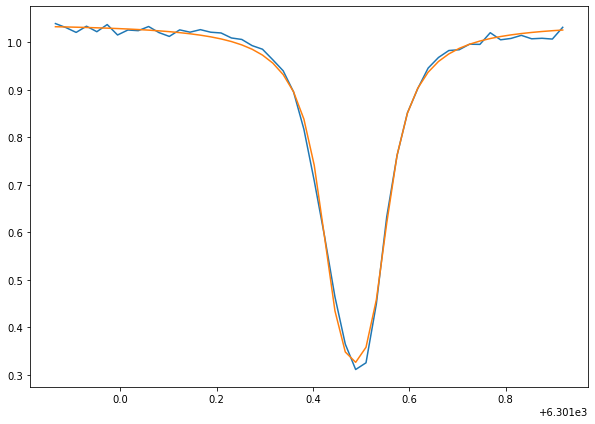

In [54]:
plt.figure(figsize=[10,7])
plt.plot(x_data,y_data)
plt.plot(x_data,me_scalar(result.x,x_data))


In [55]:
# Now the relevant probabilities
def ln_prior(params):
    # Both slope and offset positive
    a0,a1,eta,shift,width,damping = params
    if (a0 < 0):
        return -np.infty
    if (a1 < 0):
        return -np.infty
    if (eta < 0 or eta > 200.):
        return - np.infty
    if (shift < -20. or shift > 20.):
        return - np.infty
    if (shift < -10. or shift > 10.):
        return - 22.
    if (width < 0.1 or width > 10.0):
        return - np.infty
    if (damping < 1E-4 or damping > 1.0):
        return - np.infty
    return 0.

def ln_like(params, x, y, error):
    
    y_model = me_scalar(params,x)
    
    chi2 = np.sum(((y_model - y) / error)**2)
    
    return -0.5 * chi2 # - 0.5*np.log(2*np.pi) - np.log(error)) # I am making it depend on errors in purpose

def ln_post(params, x, y, error):
    
    lnprior_val = ln_prior(params)
    
    if ~np.isfinite(lnprior_val):
        return lnprior_val
    else:           
        lnlike_val = ln_like(params, x, y, error)
        return lnprior_val + lnlike_val

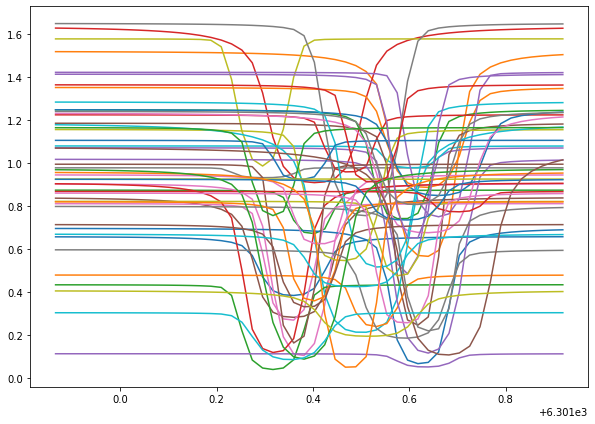

In [56]:
import emcee
ndim = 6
nwalkers = 50 # this is number of random points
i = 150
j = 150

x_data = ll[:50]
y_data = stokes[i,j,0,:50]
errors = np.zeros(50)
errors[:] = y_data[0]*1E-2


starting_params = np.zeros([nwalkers,ndim])
starting_params[:,0] = np.random.uniform(0.,1.,nwalkers)
starting_params[:,1] = np.random.uniform(0.,1.,nwalkers)
starting_params[:,2] = np.random.uniform(10.,100.,nwalkers)
starting_params[:,3] = np.random.uniform(-10.,10.,nwalkers)
starting_params[:,4] = np.random.uniform(1.0,2.0,nwalkers)
starting_params[:,5] = np.random.uniform(1E-2,1E-1,nwalkers)

plt.figure(figsize=[10,7])
for i in range (0,nwalkers):
    plt.plot(x_data,me_scalar(starting_params[i,:],x_data))

In [57]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_post, args=[x_data,y_data,errors])

num_steps = 2000
test1,test2,test3 = sampler.run_mcmc(starting_params, num_steps)

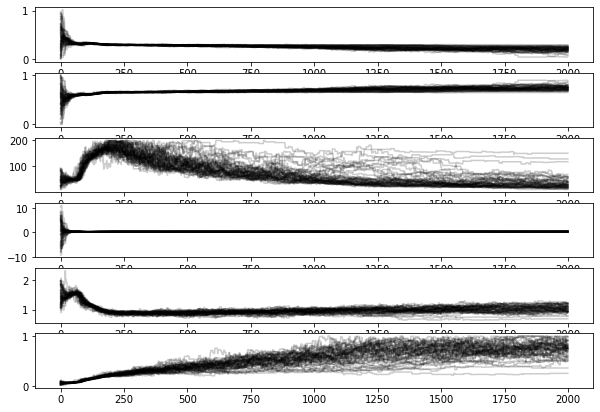

In [58]:
plt.figure(figsize=[10,7])
plt.subplot(611)
plt.plot(sampler.chain[:, :, 0].T, '-k', alpha=0.2)
plt.subplot(612)
plt.plot(sampler.chain[:, :, 1].T, '-k', alpha=0.2)
plt.subplot(613)
plt.plot(sampler.chain[:, :, 2].T, '-k', alpha=0.2)
plt.subplot(614)
plt.plot(sampler.chain[:, :, 3].T, '-k', alpha=0.2)
plt.subplot(615)
plt.plot(sampler.chain[:, :, 4].T, '-k', alpha=0.2)
plt.subplot(616)
plt.plot(sampler.chain[:, :, 5].T, '-k', alpha=0.2)

In [59]:
best = np.median(sampler.flatchain,axis=0)
print (best)

[ 0.26520849  0.67902527 61.94381262  0.36934035  0.94932688  0.50727959]


-18.908563456418108


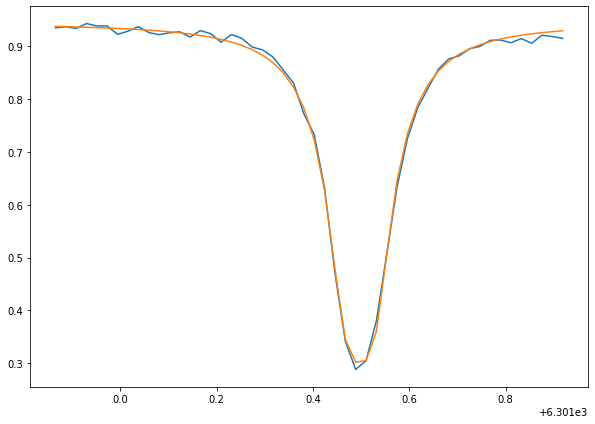

In [60]:
plt.figure(figsize=[10,7])
plt.plot(x_data,y_data)
plt.plot(x_data,me_scalar(best,x_data))
print (ln_like(best,x_data,y_data,errors))

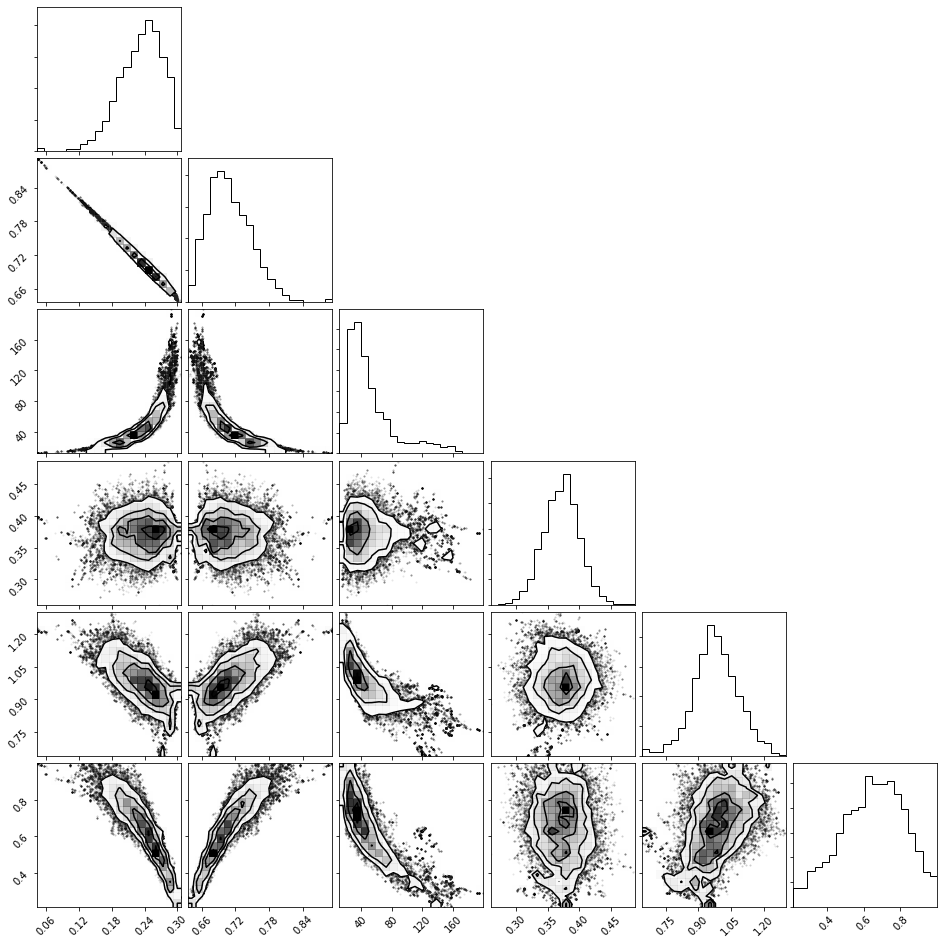

In [62]:
import corner
figure = corner.corner(sampler.flatchain[40000:])

In [26]:
from scipy.optimize import minimize

[ 1.03221151 -0.23977207  2.7335641  16.2720266   4.25571432  0.0673255 ]
[ 0.23522073  0.70762812 39.38314225  0.37083191  1.00417503  0.66746146]
[-5.05228337  5.97772548  0.33807107  0.4073417   2.89292716  0.35309981]
[ 0.16332315  0.77831564 21.21751272  0.37053831  1.12616668  0.85159414]
[ 0.27682058  0.6673374  84.44633513  0.38001271  0.91392723  0.41347716]
[ 0.15686175  0.63979978 -0.35934533 16.35984655  5.69217889 -0.05485729]
[ 0.13846263  0.80297245 18.37375447  0.37080791  1.15657313  0.89675603]
[ 0.96822436 -0.17316446  6.31392585 15.75542831  3.77232613  0.05069115]
[2.21910339e-02 7.99583532e-01 3.52336431e+01 9.75274033e+00
 1.05386089e-06 7.87420193e-02]
[ 2.16538350e-01  6.05235502e-01  1.23980969e+01 -9.88334000e+00
  5.96978468e-07  4.66884127e-02]
[-0.45643483  1.36964202  1.7137774   0.38634712  3.00589525  0.04876012]
[  0.2477818    0.70126173 176.96959178   0.35990521   0.37614009
   1.30791994]
[-2.67329841  3.60423307  0.78318247  0.37599961  2.33546719 

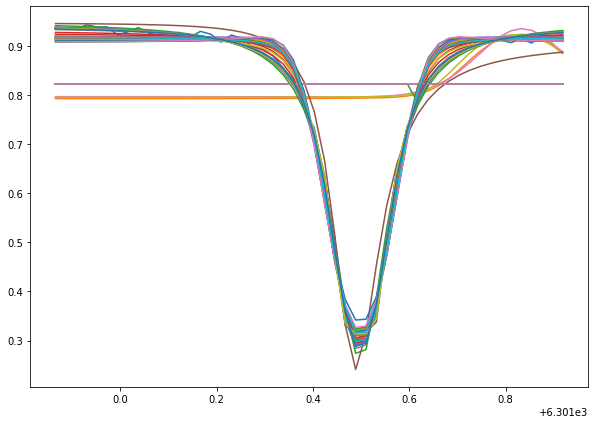